# Disseration Experiment - 10c
# Build the CC Neural Network Model
Ciaran Finnegan January 2024

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
## Import libs
import numpy as np
import pandas as pd
import random

# Display libraries
from IPython.display import display, HTML
from prettytable import PrettyTable

import raiutils
from raiutils.exceptions import UserConfigValidationException

# Feature Data Manipulation
from sklearn.preprocessing import LabelEncoder
import warnings

# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split

# Neural Network Libraries
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

2024-01-09 20:43:39.013686: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 20:43:39.016237: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 20:43:39.065040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 20:43:39.066105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 20:43:39.926343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0021 seconds
Result: Result, Execution Time: 2.0020995140075684 seconds


Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

#### Suppress Warnings to clean up output

In [5]:
warnings.simplefilter(action='ignore', category=Warning)

# Data Visualisation and Exploration

## Import Data

In [6]:
#ds_file_to_load = 'CreditCard_Fraud_Dataset_2KRows_v1-1_July2020.csv'
ds_file_to_load = 'CreditCard_Fraud_Dataset_25KRows_LargerSet_v1-0_July2020.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

### Dataset Structure

In [7]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,CardOperationsId,RunTimestamp,LOCAL_TIMESTAMP,TxnChannelCode,TxnSourceTypeCode,SourceSystemCode,AccountSourceUniqueId,CardId,CardSourceRefId,DeviceId,...,SmallOnlineAuthorizationCount.cnt.hour24,HighRiskPOSSum.acc.hour.total,HighRiskPOSSum.acc.hour.present,HighRiskPOSSum.acc.hour.past1,HighRiskPOSSum.acc.hour.past3,HighRiskPOSSum.acc.hour.past4,HighRiskPOSSum.acc.hour.past10,HighRiskPOSSum.acc.hour.past15,HighRiskPOSSum.acc.hour.past24,HighRiskPOSSum.acc.hour.past29
0,COID-1001227,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-147119,...,0,0,0,0,0,0,0,0,0,0
1,COID-1001382,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,0,0,0,0,0,0,0,0,0
2,COID-1001539,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,100,0,0,0,0,0,0,0,0
3,COID-1001540,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-316518,...,0,100,0,0,0,0,0,0,0,0
4,COID-100624,2.014030e+13,2.014030e+13,POS,External,none,ACCT-46712,CARD-624,CARD-624,DVID-54868,...,0,175,0,11,0,0,0,0,0,0


# Feature Engineering - I

## Check for Missing Data

### Volume Check - Missing Data in Dataset Columns

Identify Columns with more than three-quarters of data missing

In [8]:
# Calculate the percentage of missing data in each column
missing_data_percentage = df.isnull().mean() * 100
columns_with_high_missing_data = missing_data_percentage[missing_data_percentage > 75]

In [9]:
# Convert the series to a DataFrame for better presentation
missing_data_df = pd.DataFrame(columns_with_high_missing_data).reset_index()
missing_data_df.columns = ['Dataset Column', 'PCT of Values Missing']

# Display the DataFrame
missing_data_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

,Dataset Column,PCT of Values Missing
0,AuthResReasonCode,100.000000
1,CurrencyCodeOrig,100.000000
2,CurrencyCodeBase,100.000000
3,Secure3d,99.235912
4,Disposition,99.721426
5,ATMDepositMax.max.day.total,100.000000
6,ATMDepositMax.max.day.present,100.000000
7,ATMDepositMax.max.day.past1,100.000000
8,ATMDepositMax.max.day.past3,100.000000
9,ATMDepositMax.max.day.past4,100.000000


In [10]:
# Confirm dataframe dimentsions before check
df.shape

(25128, 380)

In [11]:
len(df)

25128

### Correct Missing Data in Dataset - 2 Columns

1. Add 'U' for 'Unknown' to the Secure3d column. Domain advise indicates that this value is relevant for credit card fraud detection.

In [12]:
# Update missing entries in the 'Secure3d' column with a 'U' character
df['Secure3d'].fillna('U', inplace=True)

In [13]:
# Verify the update
print("Amended Data Values in Secure3d column:\n")
df['Secure3d'].value_counts()

Amended Data Values in Secure3d column:



U    24936
Y      161
N       31
Name: Secure3d, dtype: int64

2. Add 'U' for 'Unknown' to the DvcPostEntryMode column. Domain advise indicates that this value is relevant for credit card fraud detection.

In [14]:
# Update missing entries in the 'DvcPosEntryMode' column with a 'U' character
df['DvcPosEntryMode'].fillna('U', inplace=True)

In [15]:
# Verify the update
print("Amended Data Values in DvcPosEntryMode column:\n")
df['DvcPosEntryMode'].value_counts()

Amended Data Values in DvcPosEntryMode column:



U               7397
E-Commerce      5897
Card Present    5655
5               3556
81               888
91               589
90               528
1                489
80                64
96                42
0                 23
Name: DvcPosEntryMode, dtype: int64

Reset threshold to 98% to remove these redundant columns

In [16]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

In [17]:
threshold

18846.0

Re-check list of columns to be dropped - ensure Secure3d not in list

In [18]:
# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

In [19]:
# Print the columns with more than 98% missing values
print("Columns with more than 98% missing values:", missing_columns)

Columns with more than 98% missing values: Index(['AuthResReasonCode', 'CurrencyCodeOrig', 'CurrencyCodeBase',
       'Disposition', 'ATMDepositMax.max.day.total',
       'ATMDepositMax.max.day.present', 'ATMDepositMax.max.day.past1',
       'ATMDepositMax.max.day.past3', 'ATMDepositMax.max.day.past4',
       'OnlinePOSCount.cnt.present'],
      dtype='object')


### Volume Check - Missing Data in Dataset Rows

In [20]:
# Remove columns with more than 75% missing data
columns_to_drop = columns_with_high_missing_data.index.tolist()
df_dropped = df.drop(columns=columns_to_drop)

# Check if any rows in the dataset still have missing data
rows_with_missing_data = df_dropped.isnull().any(axis=1).sum()
rows_with_missing_data_percentage = (rows_with_missing_data / len(df_dropped)) * 100

print("Rows with missing values, and percentage of cells with missing data:\n")
rows_with_missing_data, rows_with_missing_data_percentage

Rows with missing values, and percentage of cells with missing data:



(297, 1.1819484240687679)

In [21]:
# Identify indices of rows with missing data
indices_with_missing_data = df_dropped[df_dropped.isnull().any(axis=1)].index.tolist()

# Select a random sample of 5 indices
random_sample_indices = random.sample(indices_with_missing_data, 5)

# Extract the rows corresponding to the random sample indices
sampled_rows_with_missing_data = df_dropped.loc[random_sample_indices]

# Display the rows in a way that allows scrolling through all values
sampled_rows_with_missing_data.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}]).format(None, na_rep='MISSING')

In [22]:
# Calculate the percentage of missing data in each column of the reduced dataset
missing_data_percentage_after_dropping = df_dropped.isnull().mean() * 100
columns_with_missing_data_after_dropping = missing_data_percentage_after_dropping[missing_data_percentage_after_dropping > 0]

# Convert the series to a DataFrame for better presentation
missing_data_after_dropping_df = pd.DataFrame(columns_with_missing_data_after_dropping).reset_index()
missing_data_after_dropping_df.columns = ['Dataset Column', 'PCT of Values Missing']

In [23]:
# Order the DataFrame by 'PCT of Values Missing' in descending order
missing_data_sorted_df = missing_data_after_dropping_df.sort_values(by='PCT of Values Missing', ascending=False)

# Display the sorted DataFrame
missing_data_sorted_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

,Dataset Column,PCT of Values Missing
1,MerchantPostalCode,1.038682
3,DevicePostalCode,1.038682
4,MerchantFSA,1.038682
5,DeviceFSA,1.038682
0,MerchantCity,0.151226
2,DeviceCity,0.151226
6,OnlinePOSCount.cnt.day.past1,0.003980


Quick re-check of rows with missing values

In [24]:
# Check if any rows in the dataset still have missing data
rows_with_missing_data = df_dropped.isnull().any(axis=1).sum()
rows_with_missing_data_percentage = (rows_with_missing_data / len(df_dropped)) * 100

print("Rows with missing values, and percentage of cells with missing data:\n")
rows_with_missing_data, rows_with_missing_data_percentage

Rows with missing values, and percentage of cells with missing data:



(297, 1.1819484240687679)

Quick re-check of columns with missing values

In [25]:
# Determine the threshold for missing values
threshold2 = 0.25 * len(df)

In [26]:
# Identify columns with missing values greater than the threshold
missing_columns2 = df.columns[df.isnull().sum() > threshold2]

In [27]:
# Print the columns with more than n% missing values
print("Columns with more than n% missing values:", missing_columns2)

Columns with more than n% missing values: Index(['AuthResReasonCode', 'CurrencyCodeOrig', 'CurrencyCodeBase',
       'Disposition', 'ATMDepositMax.max.day.total',
       'ATMDepositMax.max.day.present', 'ATMDepositMax.max.day.past1',
       'ATMDepositMax.max.day.past3', 'ATMDepositMax.max.day.past4',
       'OnlinePOSCount.cnt.present'],
      dtype='object')


### Remove Cols/Rows with Missing Data (over threshold)

Drop columns with missing values greater than the threshold

In [28]:
df = df.drop(columns=missing_columns)

Drop rows with missing values - less than 1% of total dataframe

In [29]:
# Set row count before removal
iOrig_rownum = len(df)

# Remove rows with missing data from the original dataframe 'df'
#df_cleaned = df_dropped.dropna()
df = df.dropna()

# Number of rows removed
#num_rows_removed = len(df) - len(df_cleaned)
num_rows_removed = iOrig_rownum - len(df)

# Aesthetically pleasing output for the number of rows removed
num_rows_removed_output = pd.DataFrame({'Description': ['Number of Rows Removed'],
                                        'Count': [num_rows_removed]})
num_rows_removed_output.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

Description,Count
Number of Rows Removed,297


In [30]:
# Check for missing values in the cleaned dataframe
#missing_values_check = df_cleaned.isnull().sum().sum()
missing_values_check = df.isnull().sum().sum()

# Aesthetically pleasing output for the missing values check
missing_values_check_output = pd.DataFrame({'Description': ['Remaining Missing Values in DataFrame'],
                                            'Count': [missing_values_check]})
missing_values_check_output.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

Description,Count
Remaining Missing Values in DataFrame,0


In [31]:
# Confirm dataframe dimentsions after feature column amendments
df.shape

(24831, 370)

In [32]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,CardOperationsId,RunTimestamp,LOCAL_TIMESTAMP,TxnChannelCode,TxnSourceTypeCode,SourceSystemCode,AccountSourceUniqueId,CardId,CardSourceRefId,DeviceId,...,SmallOnlineAuthorizationCount.cnt.hour24,HighRiskPOSSum.acc.hour.total,HighRiskPOSSum.acc.hour.present,HighRiskPOSSum.acc.hour.past1,HighRiskPOSSum.acc.hour.past3,HighRiskPOSSum.acc.hour.past4,HighRiskPOSSum.acc.hour.past10,HighRiskPOSSum.acc.hour.past15,HighRiskPOSSum.acc.hour.past24,HighRiskPOSSum.acc.hour.past29
0,COID-1001227,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-147119,...,0,0,0,0,0,0,0,0,0,0
1,COID-1001382,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,0,0,0,0,0,0,0,0,0
2,COID-1001539,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,100,0,0,0,0,0,0,0,0
3,COID-1001540,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-316518,...,0,100,0,0,0,0,0,0,0,0
4,COID-100624,2.014030e+13,2.014030e+13,POS,External,none,ACCT-46712,CARD-624,CARD-624,DVID-54868,...,0,175,0,11,0,0,0,0,0,0


Final check that there is no missing data.

In [33]:
# Double check for missing values in the cleaned dataframe
missing_values_double_check = df.isnull().sum().sum()
missing_values_double_check

0

## Check for 'Redundant' Data

### Identify Columns with only one value

In [34]:
# Identify columns where all values are the same and their repeated values
# unique_value_counts = df_cleaned.nunique()
unique_value_counts = df.nunique()
columns_with_single_value = unique_value_counts[unique_value_counts == 1].index
single_value_columns_with_values = pd.DataFrame({
    'Column': columns_with_single_value,
    'Repeated Value': [df[col].iloc[0] for col in columns_with_single_value]
    #'Repeated Value': [df_cleaned[col].iloc[0] for col in columns_with_single_value]
})

In [35]:
# Aesthetically pleasing output for the table
single_value_columns_with_values_styled = single_value_columns_with_values.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

In [36]:
#single_value_columns_with_values_styled

### Remove Columns with only one value

In [37]:
# Remove these columns from the dataframe
#df = df_cleaned.drop(columns=columns_with_single_value)
df = df.drop(columns=columns_with_single_value)

In [38]:
# Confirm dataframe dimentsions after this phase of feature column amendments
df.shape

(24831, 263)

In [39]:
# Double check for missing values in the cleaned dataframe
missing_values_double_check = df.isnull().sum().sum()
missing_values_double_check

0

## Check for Outlier Data

### Identify Outlier Data in AmountBase Column

This column represents the value of the credit card transaction

In [40]:
# Calculating Q1, Q3, and IQR for identifying outliers in 'AmountOrig'
Q1 = df['AmountBase'].quantile(0.25)
Q3 = df['AmountBase'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [41]:
# Identify outliers
outliers = df[(df['AmountBase'] < lower_bound) | (df['AmountBase'] > upper_bound)]
print(f"Identified {len(outliers)} outliers in the 'AmountBase' column:")
print(outliers[['AmountBase']].style.format("{:.2f}").set_caption("Outliers in AmountBase"))

Identified 2340 outliers in the 'AmountBase' column:


### Remove Outlier Data in AmountBase Column

In [42]:
# Remove rows that are in the top 95% of the 'AmountOrig' column
threshold = df['AmountBase'].quantile(0.95)
data_filtered = df[df['AmountBase'] <= threshold]

In [43]:
print("Original Data Size: {}".format(len(df)))
print("Filtered Data Size after removing top 95% values: {}".format(len(data_filtered)))

Original Data Size: 24831
Filtered Data Size after removing top 95% values: 23591


In [44]:
data_filtered.shape

(23591, 263)

In [45]:
df = data_filtered

In [46]:
# Confirm dataframe dimentsions after feature outlier amendments
df.shape

(23591, 263)

### General Outlier Check

In [47]:
# Initialize an empty dataframe to hold significant outlier counts
significant_outlier_summary = pd.DataFrame(columns=['Column', 'Significant Outliers Count'])

# Iterate through each numerical column in the dataframe
for col in df.select_dtypes(include=['number']).columns:
    # Calculating Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the significant outliers (using 50 times the IQR)
    significant_upper_bound = Q3 + 50 * IQR

    # Determine significant outliers
    significant_outliers = df[df[col] > significant_upper_bound]
    significant_outlier_count = len(significant_outliers)

    # Append to summary dataframe
    significant_outlier_summary = significant_outlier_summary.append({
        'Column': col,
        'Significant Outliers Count': significant_outlier_count
    }, ignore_index=True)

In [48]:
# Displaying the results in a table format
# significant_outlier_summary.style.set_caption("Significant Outlier Counts in Each Numerical Column").hide_index()

# Dataset Exploration - Visualisations

## Generate Visualizations

#### Bar and Box Plot Visualisations

In [49]:
# Set up the target and features to be visualised

sTarget_feature = 'Fraud'
sFeature_analysis_1 = 'AmountBase'
sFeature_analysis_2 = 'CustomerPresentIndicator'
sFeature_analysis_3 = 'ECommerceFlag'
sFeature3_ticklabel1 = 'U'
sFeature3_ticklabel2 = 'Y'

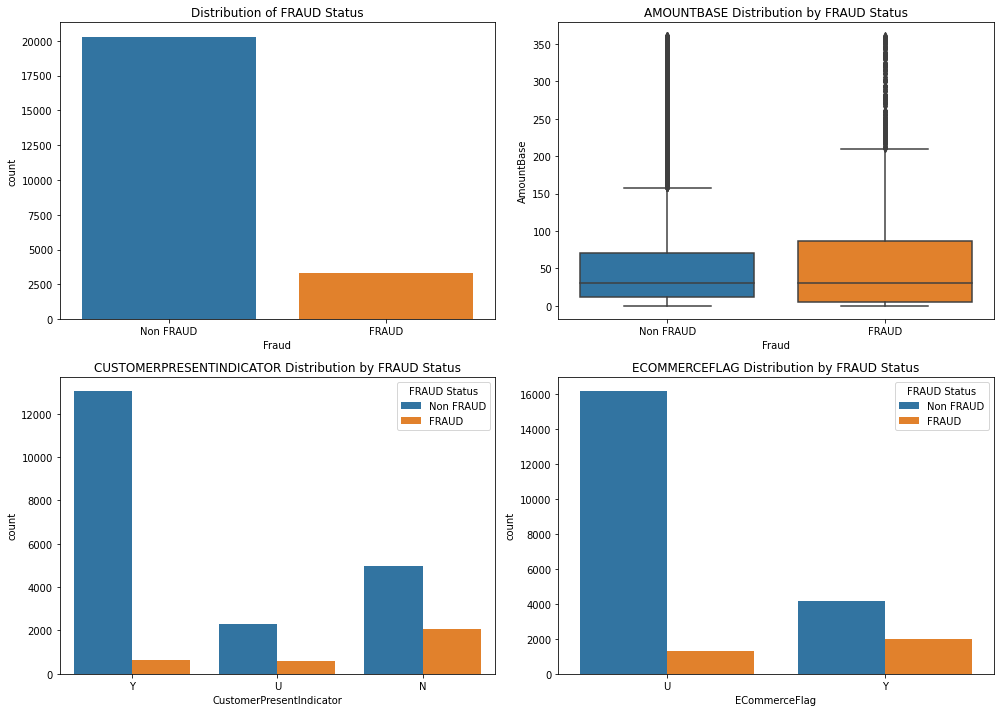

In [50]:
generate_cc_f_box_plots(df, sTarget_feature, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3,
                       sFeature3_ticklabel1, 
                       sFeature3_ticklabel2)

# Feature Engineering - II

## Feature Selection

Prior external analysis has confirmed the set of most relevant features for 'Fraud' prediction.

This is loaded to filter out remaining columns in our CC Fraud dataframe.

The 'Feature - I' adjustments are kept to illustrate the general strucure of the CC Fraud dataset.

In [51]:
# Confirm dataframe dimentsions before feature selection amendments
df.shape

(23591, 263)

In [52]:
# Path to the feature selection CSV file and the original data
feature_csv_path = 'Select_CC_Fraud_Features_v1_1.csv'
# Read the CSV file containing the selected features
selected_features_df = pd.read_csv(feature_csv_path)

In [53]:
# Extract the feature names from the 'FEATURE' column of the CSV file
selected_features = selected_features_df['FEATURE'].tolist()

In [54]:
# Drop all columns from df that are not listed in the selected features
df = df[selected_features]

In [55]:
# Display the new structure of 'df'
print("New structure of 'df':")
print(df.dtypes)

New structure of 'df':
OnlinePOSCount.cnt.day.present                    int64
EMVTransactionsCount.cnt.day.present              int64
NonEMVTransactionsCount.cnt.day.present           int64
MerchantCategory                                  int64
POS_Count.cnt.day.present                         int64
PinIndicator                                      int64
DomesticAuthCount.cnt.hour1                       int64
DomesticAuthCount.cnt.hour3                       int64
DomesticAuthCount.cnt.hour4                       int64
DomesticAuthCount.cnt.hour10                      int64
DomesticAuthCount.cnt.hour15                      int64
DomesticAuthCounter.cnt.day.present               int64
DomesticAuthCount.cnt.hour25                      int64
OnlinePOSCountForever.cnt.present                 int64
POSTerminalAttendedAuthCount.cnt.day.present      int64
CustomerNotPresentAuthCount.cnt.day.present       int64
DvcVerificationCap                                int64
ECommerceAuthCount.cnt.da

In [56]:
# Aesthetically pleasing table output to confirm the new shape of 'df'
print("\nNew Shape of 'df':")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")


New Shape of 'df':
Rows: 23591, Columns: 57


In [57]:
# Double check for missing values in the cleaned dataframe
missing_values_double_check = df.isnull().sum().sum()
missing_values_double_check

0

## Manage Categorical Values

### Identify Categorical Values

#### Show all Categorical Values w/Counts

Highlight the Categorical Values and how many unique values in each column

In [58]:
def display_CC_cat_cols_cnt(df):
    # Identify categorical columns
    categorical_features = df.select_dtypes(include=['object', 'category']).columns

    # Count the unique values in each categorical column
    unique_counts = df[categorical_features].nunique()

    # Create a DataFrame for better visualization
    visualization_df = pd.DataFrame({
        "Categorical Column": categorical_features,
        "Unique Values Count": unique_counts
    })

    # Use the style property to better present the DataFrame
    styled_df = visualization_df.style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('font-size', '12pt'), ('background-color', 'lightblue')]
        },
        {
            'selector': 'td',
            'props': [('font-size', '12pt')]
        }]
    ).set_properties(**{
        'text-align': 'left',
    }).set_caption("Categorical Columns and Unique Value Counts")

    # Display the styled DataFrame
    return unique_counts, styled_df, categorical_features

In [59]:
unique_counts, disp_df, lCatCols = display_CC_cat_cols_cnt(df)

In [60]:
disp_df

,Categorical Column,Unique Values Count
PosTerminalAttended,PosTerminalAttended,3
TxnChannelCode,TxnChannelCode,2
CustomerPresentIndicator,CustomerPresentIndicator,3
DvcPosEntryMode,DvcPosEntryMode,11
ECommerceFlag,ECommerceFlag,2


In [61]:
lCatCols

Index(['PosTerminalAttended', 'TxnChannelCode', 'CustomerPresentIndicator',
       'DvcPosEntryMode', 'ECommerceFlag'],
      dtype='object')

#### Focus on the Categorical Values with higher cardinality.

In [62]:
# Filter features with more than four unique values
features_more_than_four = unique_counts[unique_counts > 4]

# Create a PrettyTable object
table = PrettyTable()

# Define column names
table.field_names = ["Categorical Column", "Unique Values Count"]

# Populate the table with data for features with more than four unique values
for feature, count in features_more_than_four.items():
    table.add_row([feature, count])

# Print the table
print(table)

+--------------------+---------------------+
| Categorical Column | Unique Values Count |
+--------------------+---------------------+
|  DvcPosEntryMode   |          11         |
+--------------------+---------------------+


In [63]:
def get_unique_CC_categorical_values(sCatColName, df):
    # Retrieve and print unique values for the specified categorical column
    if sCatColName in df.columns:
        # Calculate the counts of each unique value in the column
        value_counts = df[sCatColName].value_counts()

        # Create a PrettyTable object for the categorical column unique values and counts
        table = PrettyTable()

        # Define column names for the table
        table.field_names = ["Unique Values in " + sCatColName, "Count"]

        # Populate the table with unique values and their counts
        for value, count in value_counts.items():
            table.add_row([value, count])

        # Print the table for the specified categorical column unique values and counts
        print("\nUnique values and counts in " + sCatColName +":")
        print(table)
    else:
        print("\n!" + "'" + sCatColName + "' column does not exist in the dataframe.")


In [64]:
get_unique_CC_categorical_values('DvcPosEntryMode', df)


Unique values and counts in DvcPosEntryMode:
+----------------------------------+-------+
| Unique Values in DvcPosEntryMode | Count |
+----------------------------------+-------+
|                U                 |  7153 |
|            E-Commerce            |  5336 |
|           Card Present           |  5132 |
|                5                 |  3481 |
|                81                |  835  |
|                91                |  589  |
|                90                |  507  |
|                1                 |  434  |
|                80                |   60  |
|                96                |   41  |
|                0                 |   23  |
+----------------------------------+-------+


### Amend Categorical Values to Numeric

#### Group Categorical Values with higher cardinality

Start with DvcPosEntryMode

In [65]:
sCatCol = 'DvcPosEntryMode'

In [66]:
def replace_values_in_column(df, column_name, values_to_replace, new_value):
    """
    Replace specified values in a DataFrame column with a new value.

    Parameters:
    df (DataFrame): The DataFrame to operate on.
    column_name (str): The name of the column in the DataFrame.
    values_to_replace (list): The values in the column to replace.
    new_value (str): The new value to replace the old values with.

    Returns:
    DataFrame: The DataFrame with updated values.
    """
    if column_name in df.columns:
        # Replace the values with the new value
        df.loc[df[column_name].isin(values_to_replace), column_name] = new_value
        print(f"Values updated in '{column_name}' column.")
    else:
        print(f"Warning: '{column_name}' column does not exist in the dataframe.")
    return df

In [67]:
# This list of entries have been indentified as a group - for 'E-Commerce'
df = replace_values_in_column(df, sCatCol, ['0', '1', '81'], 'E-Commerce')

Values updated in 'DvcPosEntryMode' column.


In [68]:
# Check Column entries after first grouping
get_unique_CC_categorical_values(sCatCol, df)


Unique values and counts in DvcPosEntryMode:
+----------------------------------+-------+
| Unique Values in DvcPosEntryMode | Count |
+----------------------------------+-------+
|                U                 |  7153 |
|            E-Commerce            |  6628 |
|           Card Present           |  5132 |
|                5                 |  3481 |
|                91                |  589  |
|                90                |  507  |
|                80                |   60  |
|                96                |   41  |
+----------------------------------+-------+


In [69]:
# This list of entries have been indentified as a group - for 'Card Present'
df = replace_values_in_column(df, sCatCol, ['5','80','90','91','96'], 'Card Present')

Values updated in 'DvcPosEntryMode' column.


In [70]:
# Check Column entries after second grouping
get_unique_CC_categorical_values(sCatCol, df)


Unique values and counts in DvcPosEntryMode:
+----------------------------------+-------+
| Unique Values in DvcPosEntryMode | Count |
+----------------------------------+-------+
|           Card Present           |  9810 |
|                U                 |  7153 |
|            E-Commerce            |  6628 |
+----------------------------------+-------+


In [71]:
unique_counts, disp_df, dfCatCol = display_CC_cat_cols_cnt(df)

Display Status of Categorical Colums after grouping

In [72]:
disp_df

,Categorical Column,Unique Values Count
PosTerminalAttended,PosTerminalAttended,3
TxnChannelCode,TxnChannelCode,2
CustomerPresentIndicator,CustomerPresentIndicator,3
DvcPosEntryMode,DvcPosEntryMode,3
ECommerceFlag,ECommerceFlag,2


#### Convert Categorical Values 

In [73]:
# Assuming 'df' is your DataFrame after all preprocessing steps
# Identify categorical columns

# categorical_features = df.select_dtypes(include=['object', 'category']).columns

In [74]:
# Perform one-hot encoding on all categorical columns
# df_encoded = pd.get_dummies(df, columns=categorical_features)  -- trying to remove duplicate code

df_encoded = pd.get_dummies(df, columns=lCatCols)

# Now df_encoded is the dataframe with one-hot encoded categorical variables

In [75]:
# display all columns
#pd.set_option('display.max_columns', None)
#print(df_encoded)

## Downsample Majority Class

In [76]:
# Check the distribution of the target variable
target_distribution = df_encoded['Fraud'].value_counts()

target_distribution

0    20306
1     3285
Name: Fraud, dtype: int64

In [77]:
# Separate the majority and minority classes
df_majority = df_encoded[df_encoded['Fraud'] == 0]
df_minority = df_encoded[df_encoded['Fraud'] == 1]

In [78]:
# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=target_distribution[1], 
                                   random_state=42)

In [79]:
# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [80]:
# Shuffle the dataset to mix the data points
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [81]:
# Display the distribution of the target variable in the downsampled dataset
df_downsampled['Fraud'].value_counts()

1    3285
0    3285
Name: Fraud, dtype: int64

## Split Features + Target

In [82]:
# Splitting the features and target variable
X = df_downsampled.drop('Fraud', axis=1)
y = df_downsampled['Fraud']

## Split Data into Test/Training Datasets

In [83]:
# Splitting the data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [84]:
X_train_downsampled.shape, X_test_downsampled.shape

((5256, 64), (1314, 64))

In [85]:
# Reset Indexes
X_train_downsampled = X_train_downsampled.reset_index(drop=True)
X_test_downsampled = X_test_downsampled.reset_index(drop=True)

y_train_downsampled = y_train_downsampled.reset_index(drop=True)
y_test_downsampled = y_test_downsampled.reset_index(drop=True)

In [86]:
X_train_downsampled.shape, X_test_downsampled.shape, y_train_downsampled.shape, y_test_downsampled.shape

((5256, 64), (1314, 64), (5256,), (1314,))

## Store Test Data to File

In [87]:
# Stored the model training and test data for use in XAI experiment Notebooks
# Jan 5th 2023 - Change sequence so that Test Data is stored BEFORE Scaling
result, X_test_df, y_test_df, X_train_df, y_train_df = store_CC_train_test_data(X_test_downsampled, 
                                                                                y_test_downsampled,
                                                                                X_train_downsampled,
                                                                                y_train_downsampled,
                                                                                df_downsampled, 
                                                                                lCatCols)  

In [88]:
print(result)

CC Data stored!


In [89]:
X_test_df.head(1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,1,0,1,5541,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,1,0


In [90]:
y_test_df.head(1)

,Fraud
0,1


In [91]:
X_train_df.head(1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,2,2,0,5462,2,1,1,1,1,2,...,0,1,0,0,1,1,0,0,1,0


In [92]:
y_train_df.head(1)

,Fraud
0,0


## Scale The Features

In [93]:
X_train_downsampled.head()

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,2,2,0,5462,2,1,1,1,1,2,...,0,1,0,0,1,1,0,0,1,0
1,-2,0,4,8999,1,0,4,4,4,4,...,1,0,1,0,0,0,1,0,0,1
2,-1,0,1,9399,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
3,-4,0,4,7399,0,0,4,4,4,4,...,1,0,1,0,0,0,1,0,0,1
4,-1,0,1,4812,0,0,1,1,1,1,...,1,0,1,0,0,0,1,0,0,1


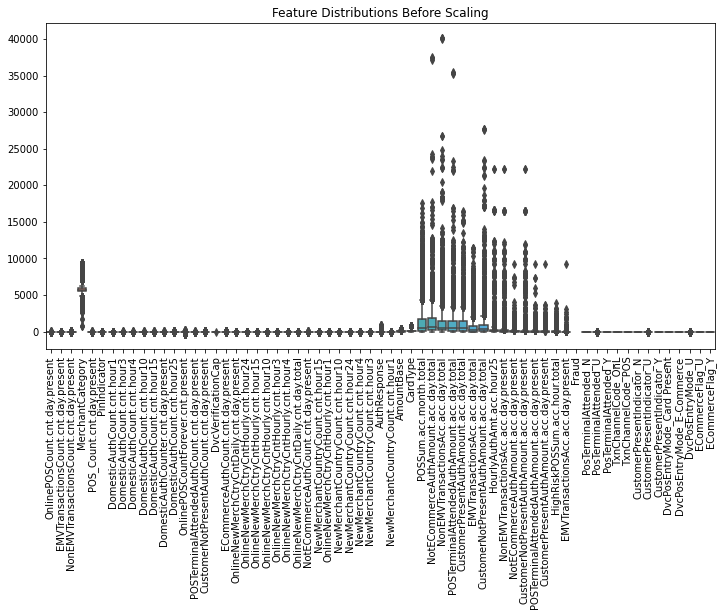

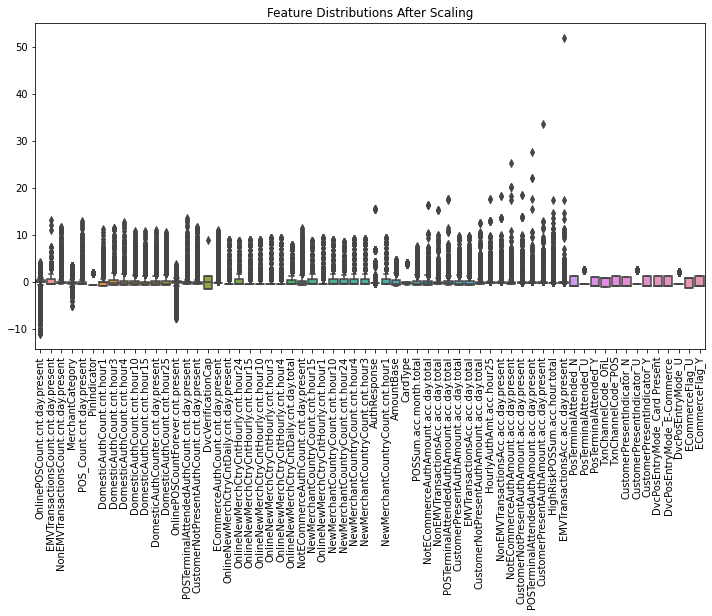

In [94]:
X_train_downsampled, X_test_downsampled = scale_the_features(X_train_downsampled, X_test_downsampled, df_downsampled, 'Fraud')

## Basic Additional Data Exploration (Training Data)

In [95]:
# Train model Stats
print("Number of Features:", X_train_downsampled.shape[1])
#print("Number Continuous Features:", X_train_downsampled.shape[1] - len(categorical_features))
#print("Number Categorical Features:", len(categorical_features))

#lCatCols
print("Number Continuous Features:", X_train_downsampled.shape[1] - len(lCatCols))
print("Number Categorical Features:", len(lCatCols))

print("Number Train Examples:", X_train_downsampled.shape[0])
print("Number Positive Train Examples:", (y_train_downsampled == 1).sum())
print("Number Negative Train Examples:", (y_train_downsampled == 0).sum())

Number of Features: 64
Number Continuous Features: 59
Number Categorical Features: 5
Number Train Examples: 5256
Number Positive Train Examples: 2635
Number Negative Train Examples: 2621


# Build Model

## Set Up Hyperparameters

Define iterations/epochs to be used in model tuning

In [96]:
number_of_trials = 5 #25
number_of_epochs = 5 #50 or 100

Set up model tuning routines

In [97]:
# Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), 
                    activation='relu', input_shape=(X_train_downsampled.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [98]:
# Set up the tuner
tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=number_of_trials,#10 or 25
        executions_per_trial=1,
        directory='my_dir',
        project_name='ccfraudxai'
)

Reloading Tuner from my_dir/ccfraudxai/tuner0.json


In [99]:
# Perform hyperparameter tuning
tuner.search(X_train_downsampled, 
             y_train_downsampled, 
             epochs=number_of_epochs,#50 or 100
             validation_split=0.2, 
             verbose=1)

In [100]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [101]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_input')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



## Build Neural Network (w/TensorFlow/Keras)

In [102]:
# Build the model with the best hyperparameters
model = build_model(best_hps)

In [103]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               12480     
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [104]:
# Fit the model
history = model.fit(X_train_downsampled, 
                    y_train_downsampled,
                    epochs=number_of_epochs,#100,  
                    batch_size=32,  
                    validation_split=0.2,  # Use part of the training data for validation
                    verbose=1)

Epoch 1/5
132/132 [==============================] - 1s 3ms/step - loss: 0.5073 - accuracy: 0.7519 - val_loss: 0.3950 - val_accuracy: 0.8165
Epoch 2/5
132/132 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.8047 - val_loss: 0.3842 - val_accuracy: 0.8279
Epoch 3/5
132/132 [==============================] - 0s 2ms/step - loss: 0.4133 - accuracy: 0.8128 - val_loss: 0.3765 - val_accuracy: 0.8251
Epoch 4/5
132/132 [==============================] - 0s 2ms/step - loss: 0.3943 - accuracy: 0.8225 - val_loss: 0.3686 - val_accuracy: 0.8327
Epoch 5/5
132/132 [==============================] - 0s 2ms/step - loss: 0.3810 - accuracy: 0.8297 - val_loss: 0.3688 - val_accuracy: 0.8298


# Evaluate Model

## Assess and Display Model Peformance

In [105]:
#X_test_downsampled

In [106]:
#y_test_downsampled.head()

In [107]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_downsampled, y_test_downsampled, verbose=0)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Accuracy: 83.33%


### Tabular Data

In [108]:
y_pred = display_model_metrics_tabular(model, X_test_downsampled, y_test_downsampled)

42/42 [==============================] - 0s 1ms/step - loss: 0.3699 - accuracy: 0.8333


42/42 [==============================] - 0s 920us/step


Metric,Value
Accuracy,0.833333
ROC AUC Score,0.917089
Precision (Class 0),0.852615
Recall (Class 0),0.810241
F1-Score (Class 0),0.830888
Precision (Class 1),0.815520
Recall (Class 1),0.856923
F1-Score (Class 1),0.835709


Tablular Done!


### Confusion Matrix

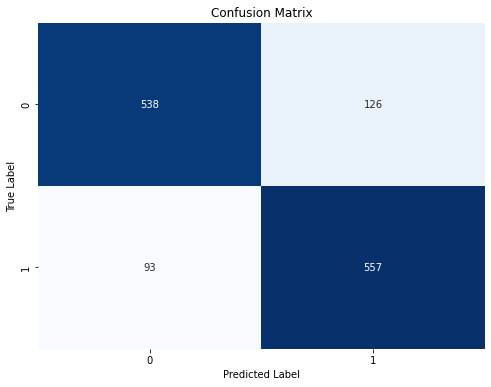

'Confusion Matrix!'

In [109]:
generate_confusion_matrix(y_test_downsampled, y_pred)

..

# Save Model

## Save Model for Re-Use

The model will be used in all the XAI metrics evaluation experiments for SHAP. LIME. ANCHORS and DiCE

In [110]:
model.save('ccfraud_model_test')  # Saves to the TensorFlow SavedModel format

INFO:tensorflow:Assets written to: ccfraud_model_test/assets


INFO:tensorflow:Assets written to: ccfraud_model_test/assets


## Check Re-Load of Model

In [111]:
loaded_model = keras.models.load_model('ccfraud_model')  # If saved as SavedModel

In [112]:
y_pred_loaded = display_model_metrics_tabular(loaded_model, X_test_downsampled, y_test_downsampled)

42/42 [==============================] - 0s 1ms/step - loss: 0.3541 - accuracy: 0.8752


42/42 [==============================] - 0s 945us/step


Metric,Value
Accuracy,0.875190
ROC AUC Score,0.942497
Precision (Class 0),0.867647
Recall (Class 0),0.888554
F1-Score (Class 0),0.877976
Precision (Class 1),0.883281
Recall (Class 1),0.861538
F1-Score (Class 1),0.872274


Tablular Done!


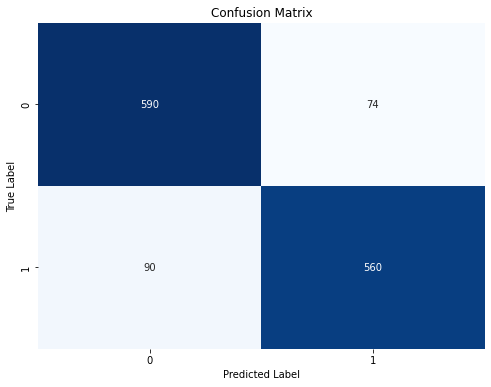

'Confusion Matrix!'

In [113]:
generate_confusion_matrix(y_test_downsampled, y_pred_loaded)